# DAE - Denoising Auto Encoder

In [7]:
# https://towardsdatascience.com/denoising-autoencoders-dae-how-to-use-neural-networks-to-clean-up-your-data-cd9c19bc6915
import torch
import torchvision
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from sklearn.model_selection import train_test_split
cpu_count = os.cpu_count()
mnist_data = torchvision.datasets.FashionMNIST('./data/', download=True, transform = torchvision.transforms.ToTensor())
X_train, X_test = train_test_split(mnist_data, test_size=0.2, train_size=0.8, random_state=909)
training_data_loader = torch.utils.data.DataLoader(X_train,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=cpu_count,
                                          )
testing_data_loader = torch.utils.data.DataLoader(X_test,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=cpu_count,
                                          )

Training data size :3000
Testing data size :750


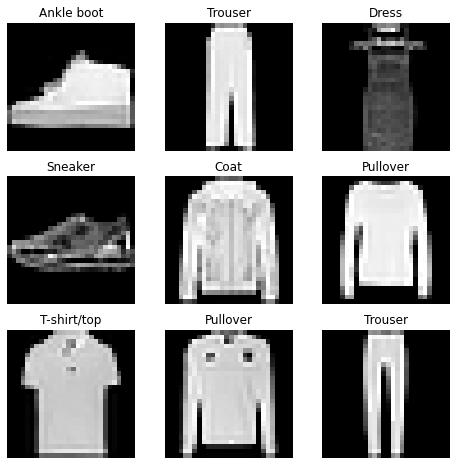

In [22]:
# Get image through dataset class
from PIL import Image 
# img, label = mnist_data[123]
# torchvision.transforms.functional.to_pil_image(img, mode=None)
# print(f'Training data size :{type(X_train)}')
print(f'Training data size :{len(training_data_loader)}')
print(f'Testing data size :{len(testing_data_loader)}')
labels = {'0' : 'T-shirt/top',
'1' :'Trouser',
'2'	:'Pullover',
'3'	:'Dress',
'4'	:'Coat',
'5'	:'Sandal',
'6'	:'Shirt',
'7'	:'Sneaker',
'8'	:'Bag',
'9'	:'Ankle boot'}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    img, label_id = X_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[str(label_id)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeeze is needed otherwise we will get error / 
                                           # TypeError: Image.__init__() takes 1 positional argument but 2 were given
plt.show()


In [ ]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# examples = next(iter(data_loader))
# for label, img  in enumerate(examples):
#    plt.imshow(img.permute(1,2,0,3))
#    plt.show()
#    print(f"Label: {label}")


